# Scientific 3D Image Analysis in Python
## Part 1: 3D Image Basics: Loading, Viewing and Simple Operations
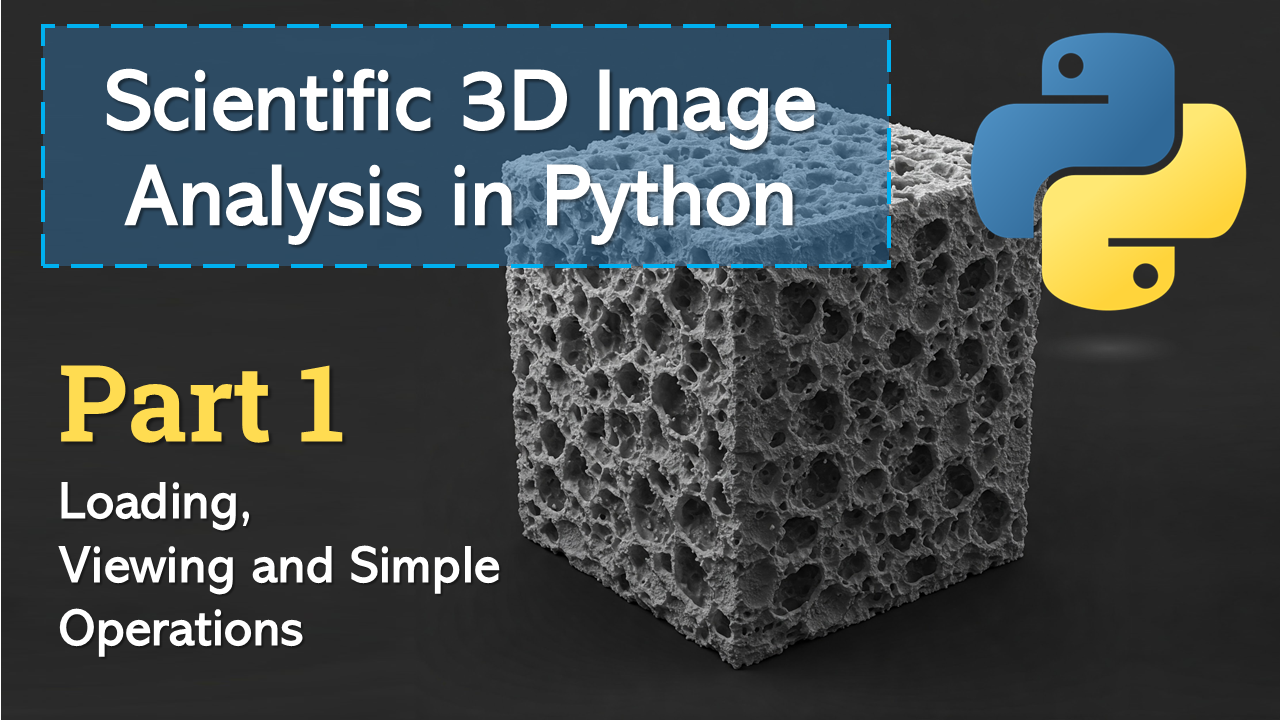

This notebook demonstrates fundamental operations for working with 3D micro-CT data, using a Mt. Simon Sandstone sample as our example. The sample has a spatial resolution of 5.22 μm per voxel.

## What we'll cover:
- Understanding image properties (dimensions, bit depth, memory requirements)
- Loading and examining .tif stacks using tifffile
- Visualizing 3D volumes using:
 - 2D slice views with matplotlib (XY, XZ, YZ planes)
 - Interactive 3D rendering with plotly
- Basic array transformations:
 - Cropping regions of interest
 - Rotating the volume
 - Flipping axes
 - Resizing (downsampling and upsampling)
- Saving processed volumes

Data source: https://www.digitalrocksportal.org/projects/324

## Import Required Libraries
First, let's import the necessary libraries for 3D image processing

In [4]:
import numpy as np              # For array operations, meshgrid creation, and numerical computations
import tifffile                # For reading and writing TIFF image stacks
import plotly.graph_objects as go     # For interactive 3D volume visualization
import matplotlib.pyplot as plt       # For 2D slice visualization
from mpl_toolkits.axes_grid1 import make_axes_locatable  # For adding colorbars to matplotlib plots
from skimage import transform         # For image transformations like rotation, resizing, and scaling

## Load the Image Stack
We'll load the TIFF stack using tifffile. This file contains multiple 2D slices that make up our 3D volume.

In [2]:
# Load the 3D image
image_path = 'cropped_250.tif'
image_3d = tifffile.imread(image_path)

# Print basic information about the dataset
print(f"Image shape: {image_3d.shape}")
print(f"Data type: {image_3d.dtype}")
print(f"Min value: {image_3d.min()}")
print(f"Max value: {image_3d.max()}")
print(f"Mean value: {image_3d.mean()}")

Image shape: (250, 250, 250)
Data type: uint8
Min value: 2
Max value: 255
Mean value: 170.73045312


## Common Bit Depths & Data Types 

### 8-bit (uint8) Images
- Values range: 0 to 2⁸-1 (0 to 255)
- Memory per pixel: 1 byte = 8 bits
- Common uses: Regular grayscale images, micro-CT
- Why use it? Perfect for most grayscale images where 256 levels are enough, small size

### 16-bit (uint16) Images  
- Values range: 0 to 2¹⁶-1 (0 to 65,535)
- Memory per pixel: 2 bytes = 16 bits
- Common uses: Scientific/medical imaging, RAW photos
- Why use it? Better detail resolution, especially in very bright/dark areas

### 32-bit (float32) Images
- Values range: Floating point numbers (±1.18e-38 to ±3.4e38)
- Memory per pixel: 4 bytes = 32 bits
- Common uses: Scientific analysis, saving continous quantities like velocity, pressure, etc.
- Why use it? Can store decimal values and very large/small numbers

### Color (RGB) Images
- Three 8-bit channels (Red, Green, Blue)
- Values per channel: 0 to 255
- Memory per pixel: 3 bytes = 24 bits
- Total possible colors: 256 × 256 × 256 = 16.7 million

## Calculating Memory Requirements

### Formula
Memory (bytes) = Width × Height × Depth × Bytes_per_pixel

### Example Calculations
For a 300×300×300 volume:
- 8-bit:  300 × 300 × 300 × 1 = 27,000,000 bytes  ≈ 27 MB
- 16-bit: 300 × 300 × 300 × 2 = 54,000,000 bytes  ≈ 54 MB
- 32-bit: 300 × 300 × 300 × 4 = 108,000,000 bytes ≈ 108 MB
- RGB:    300 × 300 × 300 × 3 = 81,000,000 bytes  ≈ 81 MB

Note: Memory is typically displayed in multiples of 1024 (1 MB = 1024 KB), but simplified to 1000 here for clarity

## Slice  visualization
Let us see how this data looks in different slices

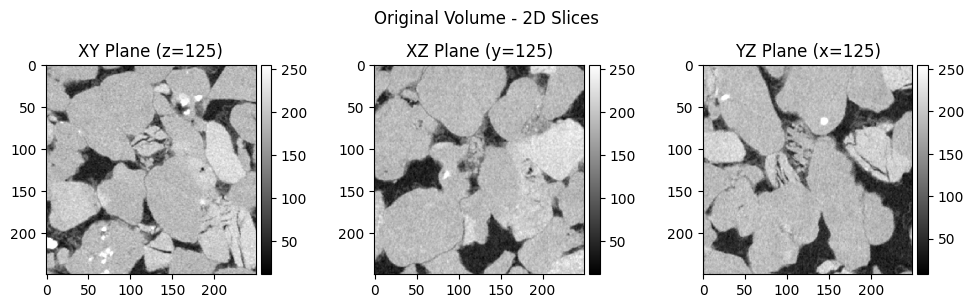

In [5]:
# 2D Slice Visualization
def plot_2d_slices(volume, title="2D Slices Visualization"):
    # Get central slices
    z_slice = volume.shape[0] // 2
    y_slice = volume.shape[1] // 2
    x_slice = volume.shape[2] // 2
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
    
    # XY plane (top view)
    im1 = ax1.imshow(volume[z_slice, :, :], cmap='gray')
    ax1.set_title(f'XY Plane (z={z_slice})')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax)
    
    # XZ plane
    im2 = ax2.imshow(volume[:, y_slice, :], cmap='gray')
    ax2.set_title(f'XZ Plane (y={y_slice})')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)
    
    # YZ plane
    im3 = ax3.imshow(volume[:, :, x_slice], cmap='gray')
    ax3.set_title(f'YZ Plane (x={x_slice})')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax)
    
    plt.suptitle(title)
    plt.tight_layout()
    return fig

# Display 2D slices of the original volume
fig_2d = plot_2d_slices(image_3d, "Original Volume - 2D Slices")
plt.show()

## Interactive Volume Visualization
Let's create functions to visualize our volume interactively using Plotly. We are going to visulize the 6 outer faces of the geometry. 

In [ ]:
def show_cube(volume):
    # Get dimensions
    nx, ny, nz = volume.shape
    
    # Convert boolean data to float if necessary
    if volume.dtype == bool:
        volume = volume.astype(float)
    
    # Get global min and max for consistent color scaling
    vmin = float(volume.min())
    vmax = float(volume.max())
    
    # Create coordinate arrays
    x = np.arange(nx)
    y = np.arange(ny)
    z = np.arange(nz)
    
    # Create meshgrids for each plane orientation
    X_xy, Y_xy = np.meshgrid(x, y)
    X_xz, Z_xz = np.meshgrid(x, z)
    Y_yz, Z_yz = np.meshgrid(y, z)
    
    # Create figure
    fig = go.Figure()
    
    # Front face (y = 0)
    fig.add_trace(go.Surface(
        x=X_xz,
        y=np.zeros_like(X_xz),
        z=Z_xz,
        surfacecolor=volume[:, 0, :].T.astype(float),
        colorscale='Greys_r',
        name='Front',
        showscale=True,
        cmin=vmin,
        cmax=vmax
    ))
    
    # Back face (y = ny-1)
    fig.add_trace(go.Surface(
        x=X_xz,
        y=np.full_like(X_xz, ny-1),
        z=Z_xz,
        surfacecolor=volume[:, -1, :].T.astype(float),
        colorscale='Greys_r',
        name='Back',
        showscale=False,
        cmin=vmin,
        cmax=vmax
    ))
    
    # Left face (x = 0)
    fig.add_trace(go.Surface(
        x=np.zeros_like(Y_yz),
        y=Y_yz,
        z=Z_yz,
        surfacecolor=volume[0, :, :].T.astype(float),
        colorscale='Greys_r',
        name='Left',
        showscale=False,
        cmin=vmin,
        cmax=vmax
    ))
    
    # Right face (x = nx-1)
    fig.add_trace(go.Surface(
        x=np.full_like(Y_yz, nx-1),
        y=Y_yz,
        z=Z_yz,
        surfacecolor=volume[-1, :, :].T.astype(float),
        colorscale='Greys_r',
        name='Right',
        showscale=False,
        cmin=vmin,
        cmax=vmax
    ))
    
    # Bottom face (z = 0)
    fig.add_trace(go.Surface(
        x=X_xy.T,
        y=Y_xy.T,
        z=np.zeros_like(X_xy.T),
        surfacecolor=volume[:, :, 0].astype(float),
        colorscale='Greys_r',
        name='Bottom',
        showscale=False,
        cmin=vmin,
        cmax=vmax
    ))
    
    # Top face (z = nz-1)
    fig.add_trace(go.Surface(
        x=X_xy.T,
        y=Y_xy.T,
        z=np.full_like(X_xy.T, nz-1),
        surfacecolor=volume[:, :, -1].astype(float),
        colorscale='Greys_r',
        name='Top',
        showscale=False,
        cmin=vmin,
        cmax=vmax
    ))
    
    # Update layout with better default view
    fig.update_layout(
        title='3D Volume Visualization',
        scene=dict(
            xaxis_title='X (voxels)',
            yaxis_title='Y (voxels)', 
            zaxis_title='Z (voxels)',
            aspectmode='data',
            camera=dict(
                eye=dict(x=2, y=2, z=1.5),
                up=dict(x=0, y=0, z=1)
            )
        ),
        width=800,
        height=800
    )
    
    return fig

# Load the data
print("Loading data...")
volume = tifffile.imread('cropped_250.tif')
print(f"Volume shape: {volume.shape}")

# Create and display the visualization
print("\nCreating visualization...")
fig = show_cube(volume)
fig.show()

print("\nVisualization controls:")
print("- Rotate: Click and drag")
print("- Zoom: Scroll wheel")
print("- Pan: Right-click and drag")

## Basic Array Operations
Now let's perform some basic operations on our 3D image


Performing cropping operation...
Cropped image shape: (125, 125, 125)

Performing rotation...
Rotated image shape: (125, 125, 125)

Performing flip operation...
Flipped image shape: (250, 250, 250)

Performing resize operations...
Downsized image shape: (62, 62, 62)
Upsampled image shape: (250, 250, 250)

Visualizing transformed volumes...


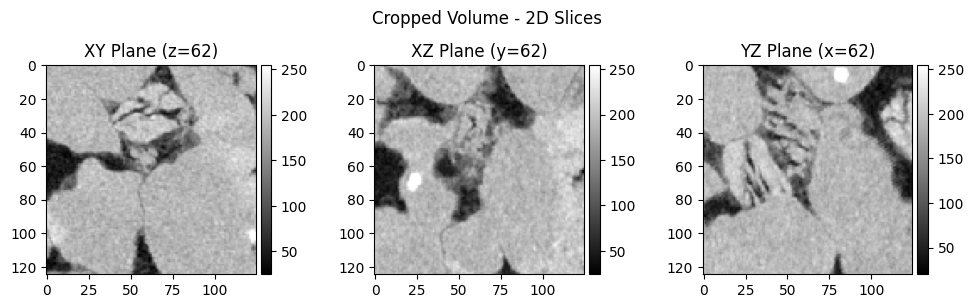

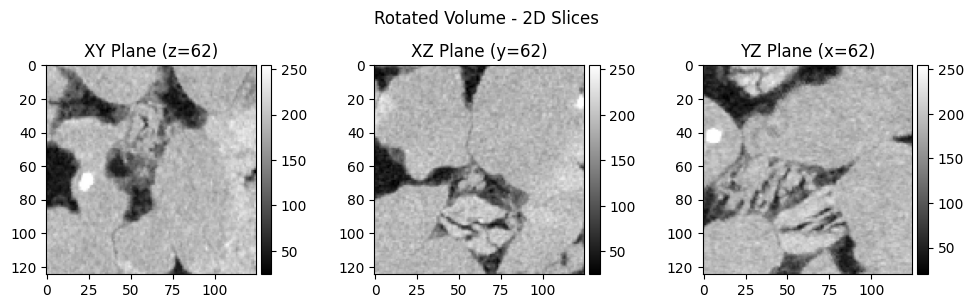

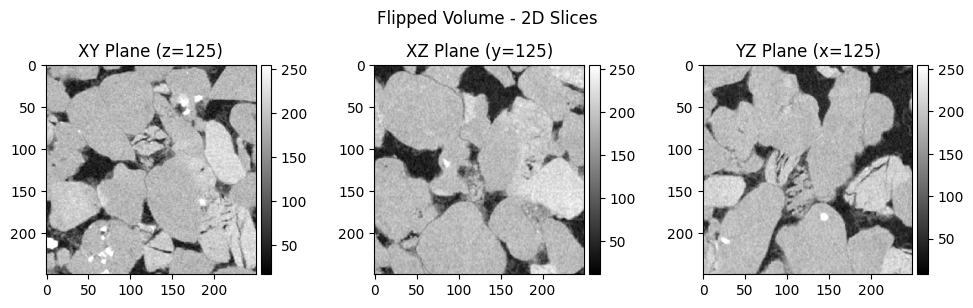

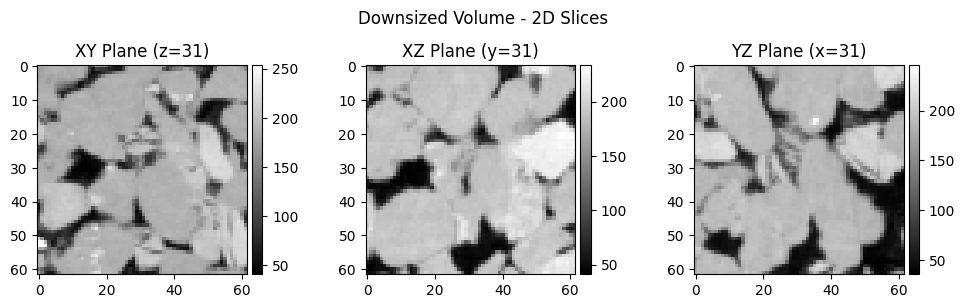

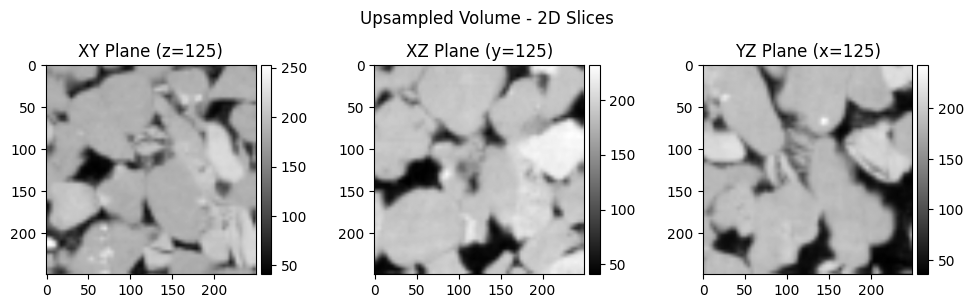

In [9]:
# 1. Cropping
print("\nPerforming cropping operation...")
x_start = image_3d.shape[0] // 4
x_end = 3 * image_3d.shape[0] // 4
y_start = image_3d.shape[1] // 4
y_end = 3 * image_3d.shape[1] // 4
z_start = image_3d.shape[2] // 4
z_end = 3 * image_3d.shape[2] // 4

cropped_image = image_3d[x_start:x_end, y_start:y_end, z_start:z_end]
print(f"Cropped image shape: {cropped_image.shape}")

# 2. Rotation (90 degrees around z-axis)
print("\nPerforming rotation...")
rotated_image = transform.rotate(cropped_image, angle=90, resize=False, preserve_range=True).astype(image_3d.dtype)
print(f"Rotated image shape: {rotated_image.shape}")

# 3. Flipping (up-down)
print("\nPerforming flip operation...")
flipped_image = np.flip(image_3d, axis=0)
print(f"Flipped image shape: {flipped_image.shape}")

# 4. Resizing
print("\nPerforming resize operations...")

# Downsize to 25% of original size
scale_factor = 0.25
new_shape = tuple(int(dim * scale_factor) for dim in image_3d.shape)
downsized_image = transform.resize(
    image_3d, 
    new_shape,
    order=1,  # Linear interpolation
    preserve_range=True,
    anti_aliasing=True
).astype(image_3d.dtype)
print(f"Downsized image shape: {downsized_image.shape}")

# Upsample back to original size
upsampled_image = transform.resize(
    downsized_image,
    image_3d.shape,
    order=1,  # Linear interpolation
    preserve_range=True,
    anti_aliasing=True
).astype(image_3d.dtype)
print(f"Upsampled image shape: {upsampled_image.shape}")

# Visualize all transformed volumes using 2D slices
print("\nVisualizing transformed volumes...")
plot_2d_slices(cropped_image, "Cropped Volume - 2D Slices")
plt.show()

plot_2d_slices(rotated_image, "Rotated Volume - 2D Slices")
plt.show()

plot_2d_slices(flipped_image, "Flipped Volume - 2D Slices")
plt.show()

plot_2d_slices(downsized_image, "Downsized Volume - 2D Slices")
plt.show()

plot_2d_slices(upsampled_image, "Upsampled Volume - 2D Slices")
plt.show()

## Save Processed Images
Let's save one of our processed images (the cropped version) as a new TIFF stack

In [ ]:
# Save the cropped image
output_path = 'cropped_125.tif'
tifffile.imwrite(output_path, cropped_image)
print(f"Saved cropped image to: {output_path}")